<a href="https://colab.research.google.com/github/parimalakettymuthu/MachineLearning-Projects/blob/main/stackExchange_NN_Multilabelclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  drive.mount('/content/drive')

  !pip install torchtext --upgrade --q
  !pip install torchmetrics --q
  !pip install -quiet torch-lr-finder --q
  !pip install wandb --q --upgrade

  basepath = '/content/drive/My Drive/NLP' 
  sys.path.append('/content/drive/My Drive/NLP/custom-functions')

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.0 MB/s eta 0:00:00

Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.4 MB/s eta 0:00:00


In [3]:
#Importing the required libraries 
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchmetrics
from torchmetrics.classification import MultilabelF1Score, MultilabelHammingDistance
from torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance

import joblib
#import swifter
import ast
import wandb

from types import SimpleNamespace
from functools import partial
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer as mlb


In [4]:
#Defined the google drive folders for accessing/saving models related files
embeddings_folder = Path(basepath)/ 'assignment7/WordEmbeddings'
data_folder = Path(basepath)/ 'assignment7/MultiLabel_Classification'
model_saving_folder = Path(basepath)/ 'assignment7/MultiLabel_Classification'

In [5]:
data_cleaned = data_folder/ "df_multilabel_hw_cleaned.joblib"
stackExchange_dataset = joblib.load(data_cleaned)

In [6]:
X = stackExchange_dataset['cleaned_text'].values
y = stackExchange_dataset['Tag_Number'].values

In [7]:
!pip install swifter -qq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 830.9/830.9 kB 12.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.9 MB/s eta 0:00:00


In [8]:
import swifter
import ast
stackExchange_dataset['Tag_Number_list'] = stackExchange_dataset['Tag_Number'].swifter.apply(lambda x: ast.literal_eval(x))

Pandas Apply:   0%|          | 0/47427 [00:00<?, ?it/s]

In [9]:
y_final = stackExchange_dataset['Tag_Number_list'].values

In [10]:
from sklearn.preprocessing import MultiLabelBinarizer as mlb
y_stackExchange_encoding = mlb().fit_transform(y_final)

In [11]:
from sklearn.model_selection import train_test_split
X_sExchange_train, X_valid_test, y_sExchange_train, y_valid_test = train_test_split(X, y_stackExchange_encoding, test_size=0.4, random_state=42)
X_sExchange_valid, X_sExchange_test, y_sExchange_valid, y_sExchange_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=42)

In [12]:
from gensim.models import KeyedVectors
pretrained_sExchange_file = str(embeddings_folder/ "model_stackExchange_CBOW.bin")
sExchange_vectors = KeyedVectors.load(pretrained_sExchange_file)

In [13]:
!pip install torch_lr_finder -qq

In [14]:
from torch_lr_finder import LRFinder
from Trainer_v4 import Trainer
from data_preparation_HW7 import * 

In [15]:
from ff_sequential_model import MLPCustom
#from ff_sequential_model_v1 import MLPCustom

In [16]:
#Creating training dataset with subset 
import random
Trainer.set_seed()
sExchange_trainset = CustomDataset(X_sExchange_train, y_sExchange_train)
se_train_subset_indices = random.sample(range(0, len(sExchange_trainset)), 500)
se_train_subset = torch.utils.data.Subset(sExchange_trainset, se_train_subset_indices)
se_vocab = get_vocab(sExchange_trainset, min_freq=2)

In [17]:
type(se_vocab), se_vocab['debug']

(torchtext.vocab.vocab.Vocab, 4164)

In [18]:
pretrained_sExchange_file = str(embeddings_folder/ "model_stackExchange_CBOW.bin")
sExchange_vectors = KeyedVectors.load(pretrained_sExchange_file)

In [19]:
pretrained_weights, words_found, words_not_found = get_pretrained_weights(
    vocab = se_vocab,
    pretrained_vectors = sExchange_vectors,
    embedding_dim = 300, #updated from 300 to 150
)

In [20]:
pretrained_weights.shape

torch.Size([90287, 300])

In [21]:
type(pretrained_weights), words_found, words_not_found

(torch.Tensor, 14664, 75623)

Initialining all required HyperParameters 

In [52]:
hyperparameters = SimpleNamespace(
# for model
    EMBED_DIM=300,
    VOCAB_SIZE=len(se_vocab),
    OUTPUT_DIM=10,
    HIDDEN_SIZES_LIST=[],
    DPROB_LIST=[],
    NON_LINEARITY=nn.SELU(),
    BATCH_NORM=False,
    
    # for optimizer
    OPTIMIZER="SGD",
    MOMENTUM=0,
    NESTEROV=False,
    
    # for training
    INITIALIZATION="default",
    EPOCHS=20,
    BATCH_SIZE=32,
    LEARNING_RATE=0.001,
    DATASET="STACKEXCHANGE",
    ARCHITECTURE="emdbag_linear",
    
    # Schedulers
    SCHEDULER="None",
)

Specifying run name & folder

In [53]:
#Defining the variables
project_name = "StackExchange NN architecture"
run_name="Task3a experiment6"
run_folder = model_saving_folder / run_name
run_folder.mkdir(exist_ok=True)
log_frequency = 5

Modifying Hyperparameters for Run

In [54]:
# # run 1 - based on default initialization
# # Notes: Final Learning rate was set to 1

# # run 2
hyperparameters.HIDDEN_SIZES_LIST = [200]
hyperparameters.DPROB_LIST = [0]
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 1.18

# # run 3
hyperparameters.OPTIMIZER = "Adam"
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 0.006

# # run 4
hyperparameters.HIDDEN_SIZES_LIST = [200] + [200]
hyperparameters.DPROB_LIST = [0] + [0]
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 0.003

# # run 5
hyperparameters.INITIALIZATION = 'kaiming'
hyperparameters.NON_LINEARITY = nn.ReLU()
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 0.003

# # run 6
hyperparameters.HIDDEN_SIZES_LIST = [400] 
hyperparameters.DPROB_LIST = [0] 
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 0.005

##run 7
# # run 6
hyperparameters.HIDDEN_SIZES_LIST = [400] + [400]
hyperparameters.DPROB_LIST = [0] 
hyperparameters.LEARNING_RATE = 0.001  # reset initial learning rate
# # Notes : Final Learning rate was set to 0.005



In [25]:
# run 1 - based on default initialization
# Notes: Final Learning rate was set to 0.01

# # run 2 - add dropout
# hyperparameters.LEARNING_RATE = 0.01   
# hyperparameters.DPROB_LIST=[0.5] 

# # run 3 - remove dropout, add weight decay
# hyperparameters.WEIGHT_DECAY = 1
# hyperparameters.DPROB_LIST=[0] 

# # run 4 - remove dropout, add weight decay
# hyperparameters.WEIGHT_DECAY = 0.1

# # run 5 - increase batch size to 256
# hyperparameters.BATCH_SIZE = 256

# # run 6 - One cyucle scheduler
# hyperparameters.LEARNING_RATE = 0.001   
# hyperparameters.WEIGHT_DECAY = 10
# hyperparameters.SCHEDULER='OneCyclicLR'
# hyperparameters.SCHEDULER_MAX_LR=0.01
# hyperparameters.SCHEDULER_DIV_FACTOR=25
# hyperparameters.SCHEDULER_FINAL_DIV_FACTOR=1e3
# hyperparameters.EPOCHS = 10

# #  run 7 - use pre-trained weights but freeze teh weights - model will 
# hyperparameters.USE_PRE_TRAINED_WEIGHTS = True
# hyperparameters.FREEZE_PRETRAINED = True

# # run 8 - Unfreeze the weights
# hyperparameters.FREEZE_PRETRAINED = False

Configuring the trainer 

In [55]:
#Set the seed value 
Trainer.set_seed()

se_collate_fn = partial(collate_batch, vocab=se_vocab)

In [56]:
type(se_collate_fn)

functools.partial

In [57]:
#Data Loader
se_train_loader, _ = get_loaders(trainset=sExchange_trainset, validset=None, 
                                         batch_size_=hyperparameters.BATCH_SIZE,
                                         collate_fn=se_collate_fn)

se_loss_function = nn.BCEWithLogitsLoss()
stackExchange_model = MLPCustom(hyperparameters.EMBED_DIM,
                                hyperparameters.VOCAB_SIZE,
                                hyperparameters.HIDDEN_SIZES_LIST,
                                hyperparameters.DPROB_LIST, 
                                hyperparameters.OUTPUT_DIM, 
                                hyperparameters.NON_LINEARITY,
                                hyperparameters.BATCH_NORM,)
                                # use_pre_trained_weights = hyperparameters.USE_PRE_TRAINED_WEIGHTS,
                                # pretrained_weights = pretrained_weights,
                                # freeze_pretrained = hyperparameters.FREEZE_PRETRAINED)
def init_weights(m):
  if type(m)=="nn.Linear":
    torch.nn.init.kaiming_normal_(m.weight)
    torch.nn.init.zeros_(nn.bias)

#Apply initialization to all modules
if hyperparameters.INITIALIZATION == 'kaiming':
  stackExchange_model.apply(init_weights)


#Defining optimizer
def get_optimizer():
  if hyperparameters.OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(
        stackExchange_model.parameters(),
        lr = hyperparameters.LEARNING_RATE,
        momentum = hyperparameters.MOMENTUM,
        nesterov = hyperparameters.NESTEROV,
    )
  else:
    optimizer = torch.optim.Adam(
        stackExchange_model.parameters(),
        lr = hyperparameters.LEARNING_RATE
    )
  return optimizer

sExchange_optimizer = get_optimizer()
sExchange_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [58]:
sExchange_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [59]:
stackExchange_model

MLPCustom(
  (non_linearity): ReLU()
  (embedding): EmbeddingBag(90287, 300, mode='mean')
  (module_list): ModuleList(
    (0): Linear(in_features=300, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

Trainer

In [60]:
sEXchange_trainer = Trainer(
    model=stackExchange_model, optimizer=sExchange_optimizer, 
    criterion=se_loss_function,
    device=sExchange_device
)
sEXchange_trainer.set_loaders(se_train_loader)

Learning Rate Finder

In [61]:
type(se_train_loader)

torch.utils.data.dataloader.DataLoader

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.86E-03


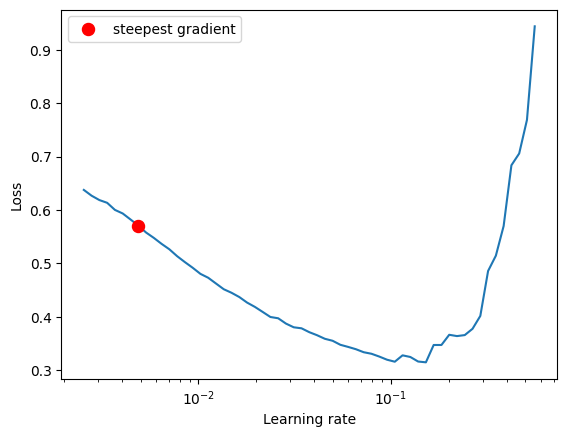

In [62]:
#sEXchange_trainer.lr_finder_range_test(sEXchange_trainer.se_train_loader)
sEXchange_trainer.lr_finder_range_test(se_train_loader)

In [63]:
#hyperparameters.LEARNING_RATE = 0.005

Set trainer based on hyperparameters

In [64]:
#Resetting optimizer
# sEXchange_trainer.set_optimizer(get_optimizer())

# # #Setting metric 
# se_train_metric = MultilabelHammingDistance(num_labels=10)
# sEXchange_trainer.set_metric(se_train_metric.to(sExchange_device))


In [65]:
#Setting wandb 
# sEXchange_trainer.set_wandb(
#   project_name = project_name,
#   run_name = run_name,
#   config = hyperparameters,
#   log_batch=True, 
#   log_frequency=log_frequency
# )

wandb: Currently logged in as: parimala-kettymuthu (parimala). Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [66]:
# sEXchange_trainer.learning_rates

[0.005]

Sanity Check

In [67]:
# sEXchange_trainer.sanity_check(num_classes=2)

Actual loss: 0.6847624358473695
Expected Theoretical loss: 0.6931471805599453


In [68]:
# sEXchange_trainer.train(num_epochs=hyperparameters.EPOCHS, multilabel=True)

Validation loader is not set. The trainer will only execute training Loop
Not saving any checkpoint
Epoch 1/20 - Train Loss: 0.1400, Train Metric: 0.0505, Train Time: 0:01:40.098131
Current Learning rate is 0.005

Epoch 2/20 - Train Loss: 0.0699, Train Metric: 0.0247, Train Time: 0:01:39.907047
Current Learning rate is 0.005

Epoch 3/20 - Train Loss: 0.0410, Train Metric: 0.0141, Train Time: 0:01:41.640469
Current Learning rate is 0.005

Epoch 4/20 - Train Loss: 0.0256, Train Metric: 0.0089, Train Time: 0:01:40.063042
Current Learning rate is 0.005

Epoch 5/20 - Train Loss: 0.0173, Train Metric: 0.0059, Train Time: 0:01:39.887301
Current Learning rate is 0.005

Epoch 6/20 - Train Loss: 0.0135, Train Metric: 0.0044, Train Time: 0:01:41.493224
Current Learning rate is 0.005

Epoch 7/20 - Train Loss: 0.0106, Train Metric: 0.0033, Train Time: 0:01:40.766340
Current Learning rate is 0.005

Epoch 8/20 - Train Loss: 0.0081, Train Metric: 0.0023, Train Time: 0:01:41.517954
Current Learning rat

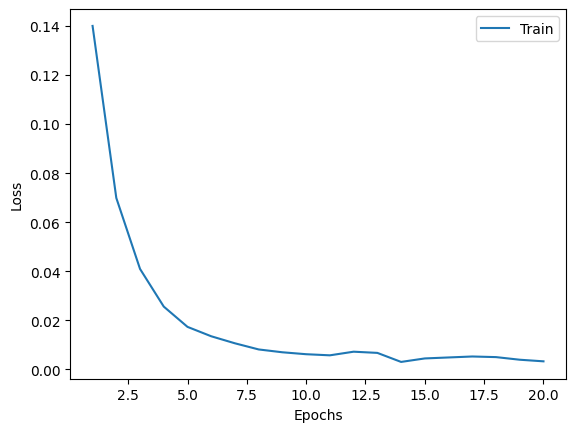

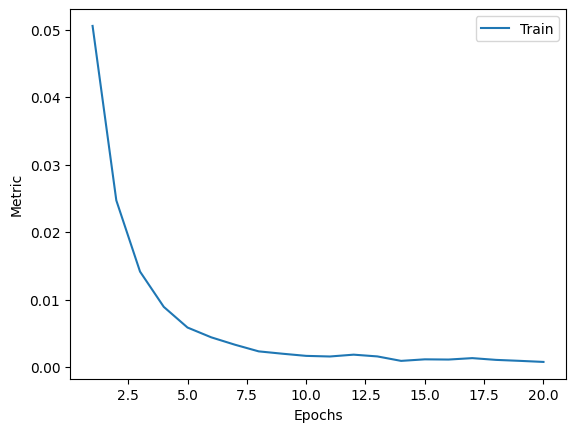

In [69]:
# sEXchange_trainer.plot_history()

Finish Run

In [70]:
# wandb.finish()

train_epoch_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_epoch_metric,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_epoch_loss,0.0033
train_epoch_metric,0.00076
